In [1]:
from IPython.display import Latex

# TP1 : Parcours des protons dans la matière

## 1.

   [METTRE RÉFÉRENCE] nous informe que l'énergie cinétique des protons utilisés en protonthérapie varie entre 11 et 220 MeV, énergies correspondant à des distances de pénétration respectives de 1mm et 30 cm. Cette dernière étant la plus creuse que nous pouvons atteindre, on en déduit que l'énergie maximale typiquement utilisée est 220 MeV. 

### Relation entre le facteur de Lorentz $\gamma$ et l'énergie du proton $T$
l'énergie totale d'un proton est la somme de son énergie de masse au repos et de son énergie cinétique tel que,

\begin{align}
E = m_p c^2 + T
\end{align}

Par contre, l'énergie totale d'un proton en mouvement est aussi éagale à $\gamma m_p c^2$. On peut ainsi écrire, 

\begin{align}
E = \gamma m_p c^2 &= m_p c^2 + T\\
\Rightarrow\ T &=  m_p c^2 (\gamma - 1)
\end{align}

Bref, en considérant la masse du proton en électron-Volts, on peut réécrire l'énergie cinétique $T$ comme,

\begin{align}
T =  m_p (\gamma - 1)\quad [eV]
\end{align}

 
### Relation entre le facteur de Lorentz $\gamma$ et la vitesse réduite $\beta$  

Sachant que $\gamma$ et $\beta$ sont définit comme,

\begin{align}
\gamma = \frac{1}{\sqrt{1-v^2/c^2}}, \qquad \beta = \frac{v}{c}
\end{align}

leur relation s'exprime comme

\begin{align}
\Rightarrow\ \gamma = \frac{1}{\sqrt{1-\beta^2}}, \qquad \beta = \sqrt{\frac{\gamma^2 - 1}{\gamma^2}}
\end{align}

## 2. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt


##5
Lorsqu'on substitue les $\gamma$ et les $\beta$ pour observer la dépendence en énergie cinétique de $\frac{\rho}{Scol}$, on arrive à l'expression:
$$\frac{\rho}{Scol} =  \frac{\rho \left(- m_{p}^{2} + \left(T + m_{p}\right)^{2}\right)}{2 \pi m_{e} n_{e} r_{e}^{2} \left(2 m_{p}^{2} + \left(T + m_{p}\right)^{2} \left(\log{\left (\frac{4 m_{e}^{2} \left(- m_{p}^{2} + \left(T + m_{p}\right)^{2}\right)^{2}}{I_{x}^{2} m_{p}^{2} \left(m_{e}^{2} + 2 m_{e} \left(T + m_{p}\right) + m_{p}^{2}\right)} \right )} - 2\right)\right)}
$$
En observant l'expression de la dérivée de la portée des protons, on remarque qu'elle n'est pas intégrable analytiquement, au moins sans faire d'énormes approximations. En effet, elle contient un log d'un polynome dépendant de l'énergie cinétique. La solution est donc simplement d'évaluer l'intégrale numériquement sur des bornes définies.

##6
On entre simplement la formule désirée dans la code si dessous avec les bons noms de constantes et il calculera l'intégrale définie en fonction de l'énergie cinétique en utilisant la méthode des trapèzes. L'expression est laissée en sympy jusqu'au dernier moment possible pour permettre la réutilisation du code pour le numéro suivant.

In [24]:
import sympy
from sympy import lambdify

#symboles sympy
re, me, c , ne, bet2, gam, I, rho, mp, T = sympy.symbols("r_e m_e c n_e \\beta^2 \gamma I_x \\rho m_p T")

#constantes
rayon_electron  = 2.8179e-13 #cm
masse_electron  = 0.510998                #Mev
masse_proton    = 938.272                  #Mev
nombre_avogadro = 6.0221409e23     #1/mol

#fonctions
facteur_de_lorenz_gamma = lambda T : T/mp + 1
facteur_de_lorenz_beta_carre =  (1- gam**(-2))
Temax = (2*me*(gam**2-1))/(1 + 2*gam*me/mp + me**2/mp**2)
Scol =  2*np.pi*re**2*me*ne/bet2 *(sympy.log(2*me*bet2*gam**2*Temax/I**2) - 2*bet2)
derivRSDCA =  rho/Scol
densite_eau = 1
densite_os = 1.85

#fonction qui entre les constantes dans l'équation puis simplifie la substitutions des autres variables
derivRSDCA_subs = lambda densite, densite_electronique, excitation : (derivRSDCA.subs(
                [(bet2, facteur_de_lorenz_beta_carre)
                ,(gam, facteur_de_lorenz_gamma(T))
                ,(re, rayon_electron)
                ,(me, masse_electron)
                ,(ne, densite_electronique)
                ,(mp, masse_proton)
                ,(I, excitation)
                ,(rho, densite)])/densite)

#méthode des trapezes générale
def integral_trapese(fonction, resolution, debut, fin):
    trapeze = lambda values, interval: interval * (values[0] / 2 + np.sum(values[1:-1]) + values[-1] / 2)
    nombre = 1
    prev = 0
    output_change = 1337
    while True :
        condition = abs(output_change) / 3 > resolution
        interval = (fin - debut) / nombre
        xvalues = [i for i in np.arange(debut, fin + interval, interval)]
        yvalues = [fonction(i) for i in xvalues]
        integral_result = trapeze(yvalues, interval)
        if not condition:
            return prev, nombre // 2, output_change
        if nombre != 1:
            output_change = integral_result - prev
        prev = integral_result
        nombre *= 2

#substitutions des constantes dépendantes du matériau dans l'équation
derivRSDCA_eau = lambda energie_cinetique : derivRSDCA_subs(
    densite              = 1,            #g/cm**3
    excitation           = 75e-6,     #MeV
    densite_electronique = 5/9*nombre_avogadro).subs(T, energie_cinetique)

derivRSDCA_os_cortical = lambda energie_cinetique : derivRSDCA_subs(
    densite              =  1.85,             #g/cm**3
    excitation           = 106.4e-6, #MeV
    densite_electronique = 0.96*nombre_avogadro).subs(T, energie_cinetique)

#changement de sympy à une expression plus rapide à évaluer
derivRSDCA_eau = lambdify(T, derivRSDCA_eau(T))
derivRSDCA_os_cortical = lambdify(T, derivRSDCA_os_cortical(T))

#Calcul des intégrales pour l'eau et l'os cortical
RSDCA_eau, nombre_eau, erreur_eau= integral_trapese(
    fonction   = derivRSDCA_eau,
    resolution = 1e-9,  #cm
    debut      = 3,       #MeV
    fin        = 220)     #MeV

RSDCA_os_cortical, nombre_os_cortical, erreur_os = integral_trapese(
    fonction   = derivRSDCA_os_cortical,
    resolution = 1e-9, # cm
    debut      = 3,      # MeV
    fin        = 220)    # MeV

print("RSDCA eau         : ", RSDCA_eau,"cm avec {} trapezes et {} d'erreur".format(nombre_eau, erreur_eau))
print("RSDCA os cortical : ", RSDCA_os_cortical,"cm avec {} trapezes et {} d'erreur".format(nombre_os_cortical, erreur_os))


RSDCA eau         :  30.5046168919 cm avec 131072 trapezes et 1.014779371644181e-09 d'erreur
RSDCA os cortical :  18.4612299766 cm avec 65536 trapezes et 2.510454066850798e-09 d'erreur


In [11]:
from IPython.display import Latex

##7

On peut déduire l'expression analytique de la dérivée pouvoir d'arrêt en fonction de T. Nous commençons par faire les substitutions suivantes:
\begin{align}
a &=2 m_{e} \\ 
 b &=\frac{m_{e}^{2}}{m_{p}^{2}} + 1 \\ 
 c &=\frac{m_{e}}{m_{p}} \\ 
 k &=\frac{a^2}{I_{x}^{2}} \\ 
 U &=2 \pi n_{e} r_{e}^{2}
\end{align}
Dans
\begin{align}
\frac{2 \pi}{\beta^2} m_{e} n_{e} r_{e}^{2} \left(  \log{\left (\frac{2 \beta^2}{I_{x}^{2}} T_{e_{max}} \gamma^{2} m_{e} \right )}- 2 \beta^2\right)
\end{align}
On obtient :

\begin{align}
Scol &= U\frac{m_e}{\beta^2} \left(log \left( \frac{\beta^2 k m_e(\gamma^2 -1)}{(b + c\gamma)}\right) - 2\beta^2\right) \\
&= U\frac{m_e}{1 - \gamma^{-2}} \left(log(km_e) + log(1 - \gamma^{-2}) + log(\gamma^2 -1) - log(b + c\gamma) - 2(1 - \gamma^{-2})\right)
\end{align}
Qu'on doit dériver par rapport à $\gamma$. Les dérivés suivantes servent à accélérer le calcul:
\begin{align}
\frac{d}{dx}(1 - x^{-2}) = 2x^{-3}\\
\frac{d}{dx}(1 - x^{-2})^{-1} = \frac{2x}{(x^2 - 1)^2}
\end{align}
En faisant alors quelques dérivés simples, on arrive à:
\begin{align}
\frac{d Scol}{d\gamma} &= U\frac{2\gamma m_e}{(\gamma^2 - 1)^2} \left(log(km_e) + log(1 - \gamma^{-2}) + log(\gamma^2 -1) - log(b + c\gamma) - 2(1 - \gamma^{-2})\right) \\
&\ +U\frac{m_e}{1 - \gamma^{-2}} \left(\frac{2\gamma^{-3}}{(1 - \gamma^{-2})} + \frac{2\gamma}{(\gamma^2 -1)} - \frac{c}{(b + c\gamma)} - 4\gamma^{-3}\right)
\end{align}

Par le théorème de dérivation des fonctions composées, on sait que $\frac{d Scol}{dT} = \frac{d Scol}{d\gamma}\frac{d \gamma}{dT}$. On trouve alors que:
\begin{align}
\frac{d \gamma}{dT} = \frac{d}{dT} \frac{T}{m_p} + 1 = \frac{1}{m_p}
\end{align}
Le $m_p^{-1}$ va simplement aller se simplifier avec le $m_e$ du début des deux termes pour générer un $c$. On a alors simplement:
\begin{align}
\frac{d Scol}{dT} &= U\frac{2\gamma c}{(\gamma^2 - 1)^2} \left(log(km_e) + log(1 - \gamma^{-2}) + log(\gamma^2 -1) - log(b + c\gamma) - 2(1 - \gamma^{-2})\right) \\
&\ +U\frac{c}{1 - \gamma^{-2}} \left(\frac{2\gamma^{-3}}{(1 - \gamma^{-2})} + \frac{2\gamma}{(\gamma^2 -1)} - \frac{c}{(b + c\gamma)} - 4\gamma^{-3}\right)
\end{align}
Qui se simplifie en:
\begin{align}
\frac{d Scol}{dT} &= U\frac{2\gamma^{-3} c}{\beta^4} \left(log\left(\frac{km_e\beta^2(\gamma^2-1)}{b + c\gamma}\right) - 2\beta^2\right) +U\frac{c}{\beta^2} \left(\frac{2\gamma^{-3}}{\beta^2} + \frac{2\gamma}{(\gamma^2 -1)} - \frac{c}{(b + c\gamma)} - 4\gamma^{-3}\right)
\end{align}

Comme on sait que la dérivée analytique existe et est assez simple, on fait confiance à sympy pour la calculer avec justesse, et on trace la dérivée sur le domaine d'intérêt.

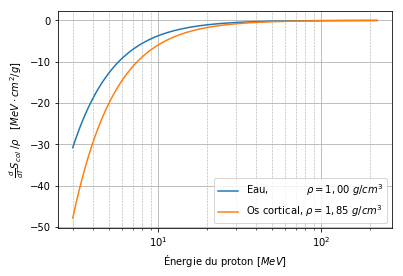

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
Scol_subs = lambda densite, densite_electronique, excitation : ((Scol).subs(
                [(bet2, facteur_de_lorenz_beta_carre)
                ,(gam, facteur_de_lorenz_gamma(T))
                ,(re, rayon_electron)
                ,(me, masse_electron)
                ,(ne, densite_electronique)
                ,(mp, masse_proton)
                ,(I, excitation)
                ,(rho, densite)]))

derivScol_eau = lambda energie_cinetique : sympy.diff(Scol_subs(
    densite              = 1,            #g/cm**3
    excitation           = 75e-6,     #MeV
    densite_electronique = 5/9*nombre_avogadro),T).subs(T, energie_cinetique)

derivScol_os_cortical = lambda energie_cinetique : sympy.diff(Scol_subs(
    densite              = 1.85,             #g/cm**3
    excitation           = 106.4e-6, #MeV
    densite_electronique = 0.96*nombre_avogadro),T).subs(T, energie_cinetique)

derivScol_eau = lambdify(T, derivScol_eau(T))
derivScol_os_cortical = lambdify(T, derivScol_os_cortical(T))

xvalues = [i for i in np.arange(3,220,0.01)]
plt.plot(xvalues, [derivScol_eau(i) for i in xvalues], label=r"Eau,            $\rho = 1,00\ g/cm^3$")
plt.plot(xvalues, [derivScol_os_cortical(i) for i in xvalues], label=r"Os cortical, $\rho = 1,85\ g/cm^3$")
plt.xscale('log')
plt.grid('True', which='Major')
plt.grid('True', which='Minor', ls='--', linewidth=0.6)
plt.xlabel(r'Énergie du proton $[MeV]$')
plt.ylabel(r"$\frac{d}{dT}S_{col}\;/\rho\quad[MeV\cdot cm^2/g]$")
plt.legend()
plt.show()

##8

Comme nous connaissons la dérivée du pouvoir d'arrêt, il est possible d'évaluer l'erreur d'approximation faite par l'intégration de $f(x)$ entre $a$ et $b$ avec la méthode des trapèzes. En effet, nous savons que:
\begin{align}
\epsilon = \frac{1}{12}h^2\left[f'(a) - f'(b) \right]
\end{align}
Par contre, on ne peut pas tout de suite utiliser le résultat du numéro précédent puisque nous intégrons l'inverse du pouvoir d'arrêt. Sa dérivée est alors:
\begin{align}
\frac{d}{dT}\frac{1}{Scol} = -\left(Scol\right)^{-2}\cdot \frac{d Scol}{dT}
\end{align}
On peut alors maintenant évaluer $\epsilon$ à l'aide du résultat précédent et trouver que:



In [25]:

Scol_eau = lambda energie_cinetique : Scol_subs(
    densite              = 1,            #g/cm**3
    excitation           = 75e-6,     #MeV
    densite_electronique = 5/9*nombre_avogadro).subs(T, energie_cinetique)

Scol_os_cortical = lambda energie_cinetique : Scol_subs(
    densite              =  1.85,             #g/cm**3
    excitation           = 106.4e-6, #MeV
    densite_electronique = 0.96*nombre_avogadro).subs(T, energie_cinetique)

Scol_eau = lambdify(T, Scol_eau(T))
Scol_os_cortical = lambdify(T, Scol_os_cortical(T))

xvalues = [i for i in np.arange(3,220+0.01,0.01)]
eau_penet = [-Scol_eau(i)**(-2)*derivScol_eau(i) for i in xvalues]
os_penet = [-Scol_os_cortical(i)**(-2)*derivScol_os_cortical(i) for i in xvalues]

print("\epsilon eau : {}".format(1/12*((220-3)/131072)**2*(eau_penet[0] - eau_penet[-1])))
print("\epsilon os : {}".format(1/12*((220-3)/131072)**2*(os_penet[0] - os_penet[-1])))




\epsilon eau : 3.382630111050522e-10
\epsilon os : 2.092046229071302e-10


\begin{align}
\epsilon_{eau}\ :\ 3.382630111050522\times 10^{-10} cm \\
\epsilon_{os}\ \ :\ 2.092046229071302\times 10^{-10} cm
\end{align}
Qui se compare à nos valeurs calculées précédemment, qui sont
\begin{align}
Erreur\ eau\ :\ 1.014779371644181\times 10^{-9} cm  \\
Erreur\ os\ \ :\ 2.510454066850798\times 10^{-9} cm
\end{align}
On voit tout de suite que l'erreur d'approximation calculée lors de l'intégration est systématiquement sous son expression analytique.
\\
Ceci est tout à fait logique puisque pour calculer la vraie erreur lors de l'intégration, il faudrait comparer l'ensemble de N trapèzes à un ensemble d'une infinité de trapèzes au lieu de 2N trapèzes. L'ensemble de 2N trapèzes a lui-même une erreur qui n'est pas considérée ici, tout comme 4N, 8N, 16N et ainsi de suite. 
\\
Par contre, on remarque qu'on se trouve dans le bon ordre de grandeur, où l'erreur d'arrondissement devient plus grande que l'erreur d'approximation, ce qui rendrait tout calcul subséquant inutile. On pourrait donc dire que notre méthode d'intégration a suffisament convergé.

##13
On sait qu'il est possible de calculer l'énergie déposée pour un pas de déplacement du proton comme :
$$ s = \int_{T_f}^{T_i} \frac{dT'}{S_{col}}$$
On veut alors écrire un algorithme capable de réaliser le transport des protons subissant une décélération
continue dans le milieu et tracer le dépôt d’énergie en fonction de la profondeur pour l’eau
et l’os pour des proton d’énergie cinétique 100 MeV. 
\\
Pour ce faire, il est nécessaire d'engendrer un processus itératif. En effet, on commence avec une énergie de départ, 100MeV, puis on calcule combien d'énergie le proton perd après s'être déplacé d'un certain $\Delta s$. On prend en note ce $\Delta T$ et on le soustrait à l'énergie initiale. La nouvelle énergie est alors considérée comme énergie initiale et on reccomence le processus jusqu'à ce que l'énergie tende vers 0.

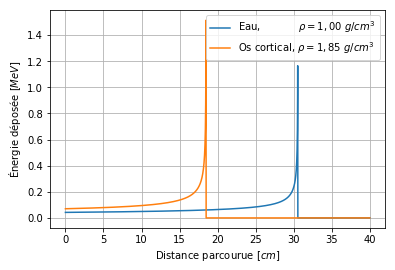

In [15]:
ds = 0.01
s_mat =[i for i in np.arange(0, 40, ds)]

def depot_energie(fonction, distance, energy = 220, step = 0.1):
    begin, end, N = 3, 100, 1000
    delta_T_mat = []
    for i in distance:
        if energy > 3:
            delta_T = ds*fonction(energy)
            energy -= delta_T
            delta_T_mat.append(delta_T)
        else: 
            delta_T_mat.append(0)
    return delta_T_mat

plt.plot(s_mat, depot_energie(Scol_eau, s_mat, step = ds), label = r"Eau,            $\rho = 1,00\ g/cm^3$")
plt.plot(s_mat, depot_energie(Scol_os_cortical, s_mat, step = ds), label=r"Os cortical, $\rho = 1,85\ g/cm^3$")
plt.grid('True', which='Major')
plt.grid('True', which='Minor', ls='--', linewidth=0.6)
plt.xlabel(r'Distance parcourue $[cm]$')
plt.ylabel(r"Énergie déposée $[MeV]$")
plt.legend()
plt.show()

##14

Le pic de Bragg, qu'on observe dans le graphique précédent, montre que, lors de la pénétration, le proton va déposer la majorité de son énergie vers la fin de sa trajectoire. 


Cela permet, en radiothérapie, de traiter une zone précise en profondeur sans trop affecter les tissus entre l'emetteur et la zone à traiter. 

On note aussi qu'on y trouve même la longueur de pénétration sans avoir à évaluer l'intégrale.

##15

Comme nous voulons positionner le pic de Bragg sur la région à traiter, il suffit de calculer sa position en fonction de l'énergie initiale. Pour ce faire, on utilise la fonction définie au numéro 13 et on trouve son maximum pour toutes les énergies initiales. On se retrouve ainsi avec la position du pic de Bragg en fonction de l'énergie initiale. On calcule ainsi l'énergie nécessaire à avoir le pic de Bragg à 4cm, qui donne :
$$ E_{4cm} = 69.36MeV$$


69.39


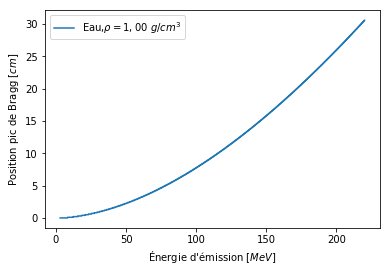

In [23]:
energy_mat = [i for i in np.arange(3, 220, 0.01)]
distance_mat = []
ds = 0.1
s_mat =[i for i in np.arange(0, 35, ds)]
for T in energy_mat:
    depo_mat = depot_energie(Scol_eau, s_mat, energy = T, step = ds)
    distance_mat.append(ds*np.argmax(depo_mat))
    
plt.plot(energy_mat, distance_mat, label = r"Eau,$\rho = 1,00\ g/cm^3$")
plt.xlabel(r"Énergie d'émission $[MeV]$")
plt.ylabel(r"Position pic de Bragg $[cm]$")
plt.legend()

prev = 0
for i in range(0,len(distance_mat)):
    if 4-distance_mat[i] < 0:
        index = i - (abs(4-distance_mat[i-1]) > abs(4-distance_mat[i]))
        value = energy_mat[index]
        break
print(value)

plt.show()


##16

srx wtf c'Est un peu trop de la physique médicale

##17

Il va falloir inclure la diffusion de protons dans notre modèle.